In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, Markdown, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

def _IMPORT_(x):
    try:
        segs = x.split(' ')
        g = globals()
        if 'github.com' in segs[1]:
            uri = segs[1].replace('github.com', 'raw.githubusercontent.com')
            mod = uri.split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif 'gitee.com' in segs[1]:
            mod = segs[1].split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/raw/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif segs[1][0] == '/':
            with open(segs[1] + '.py') as fr:
                x = fr.read()
        exec(x, g)
    except:
        pass

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

def img2b64(x):
    if isinstance(x, bytes):
        return base64.b64encode(x).decode()
    elif isinstance(x, str):
        with open(x, 'rb') as fr:
            return base64.b64encode(fr.read()).decode()
    raise


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [4]:
###
### Common ###
###

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_table(headers, data, width=900):
    ncols = len(headers)
    width = int(width / ncols)
    lralign = []
    caption = []
    for item in headers:
        astr = ''
        if item[0] == ':':
            astr = ':'
            item = item[1:]
        astr += '---'
        if item[-1] == ':':
            astr += ':'
            item = item[:-1]
        lralign.append(astr)
        caption.append(item)
    captionstr = '|'.join(caption) + chr(10)
    lralignstr = '|'.join(lralign) + chr(10)
    imgholdstr = '|'.join(['<img width=%d/>' % width] * ncols) + chr(10)
    table = captionstr + lralignstr + imgholdstr
    is_dict = isinstance(data[0], dict)
    for row in data:
        if is_dict:
            table += '|'.join([f'{row[c]}' for c in caption]) + chr(10)
        else:
            table += '|'.join([f'{col}' for col in row]) + chr(10)
    return Markdown(table)

def show_video(vidsrc, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if vidsrc.startswith('http'):
        data_url = vidsrc
    else:
        mp4 = open(vidsrc, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    if url.startswith('http'):
        response = requests.get(url)
        if response:
            imgmat = np.frombuffer(response.content, dtype=np.uint8)
            img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        else:
            return None
    else:
        img = cv2.imread(url)
        
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size:
        if isinstance(size, int):
            size = (size, size)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img


## Read Image

In [5]:
img_lena = im_read('https://gitee.com/qrsforever/blog_source_assets/raw/master/AI/opencv/lena.jpg')

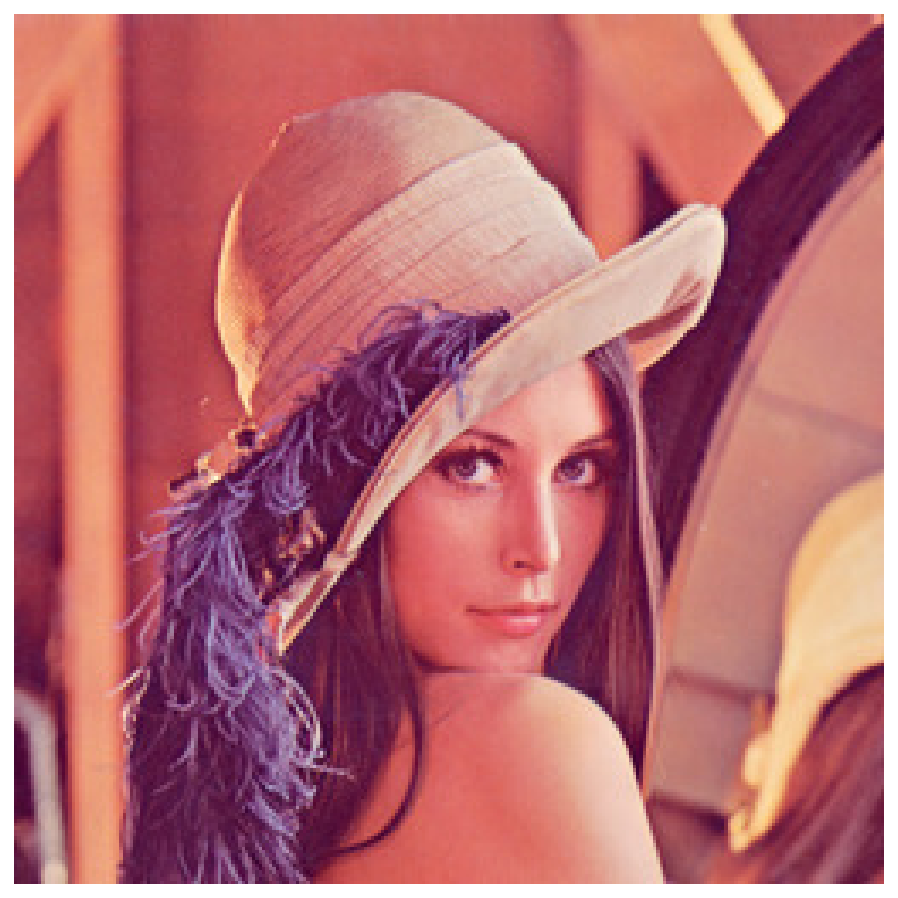

In [6]:
show_image(img_lena)

In [21]:
a = [img_lena] * 3

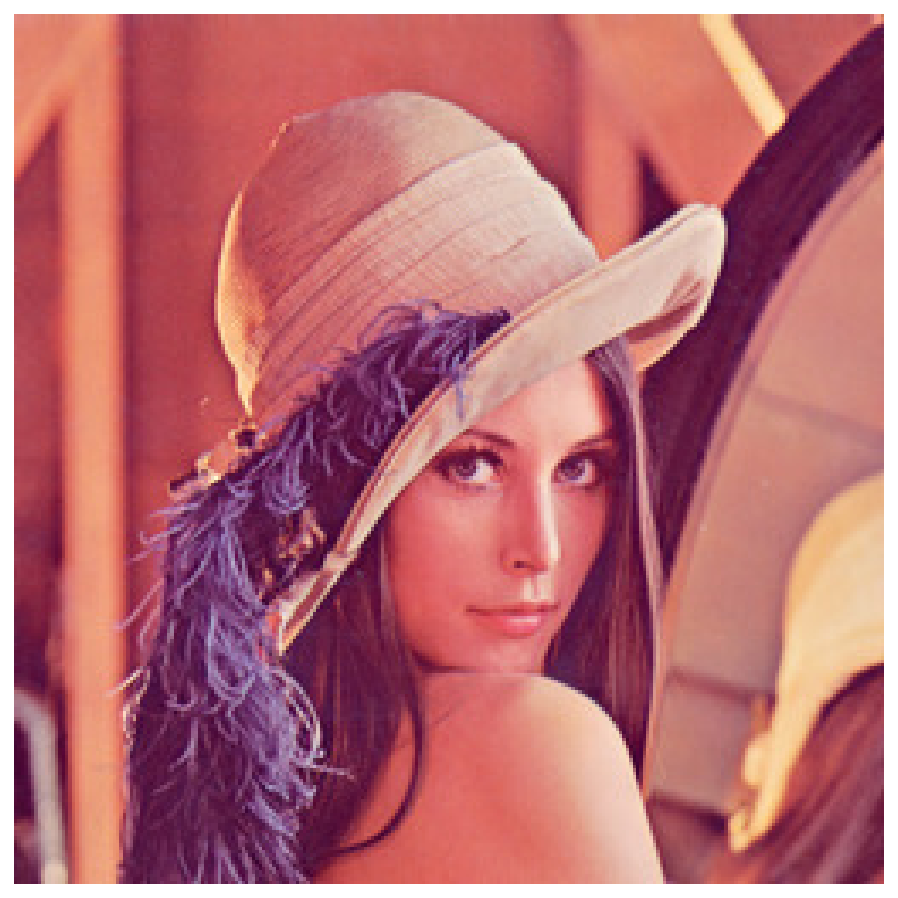

In [25]:
show_image(a[2])

In [8]:
height, width, channels = img_lena.shape
height, width, channels

(256, 256, 3)

In [36]:
img_1 = img_lena[50:150, 50:150, :]

(100, 200, 3)


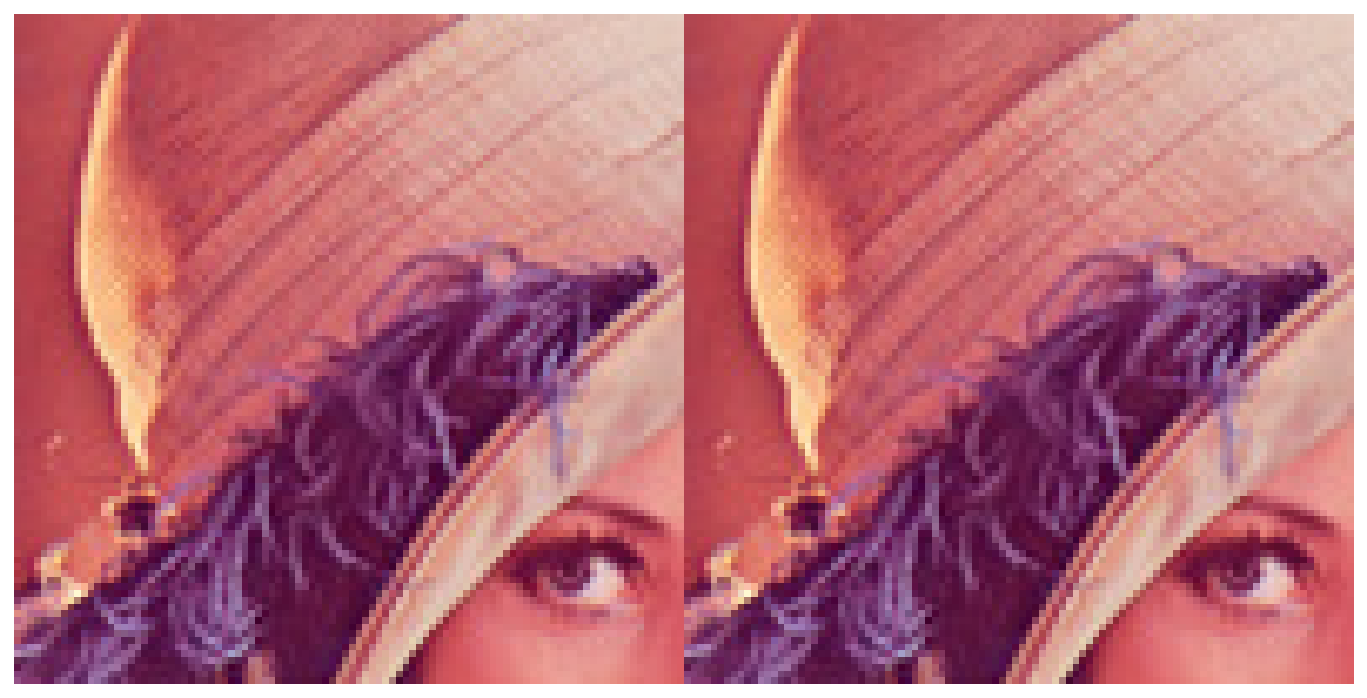

In [41]:
img_2 = np.hstack([img_1]*2)
print(img_2.shape)
show_image(img_2)

(100, 200, 3)


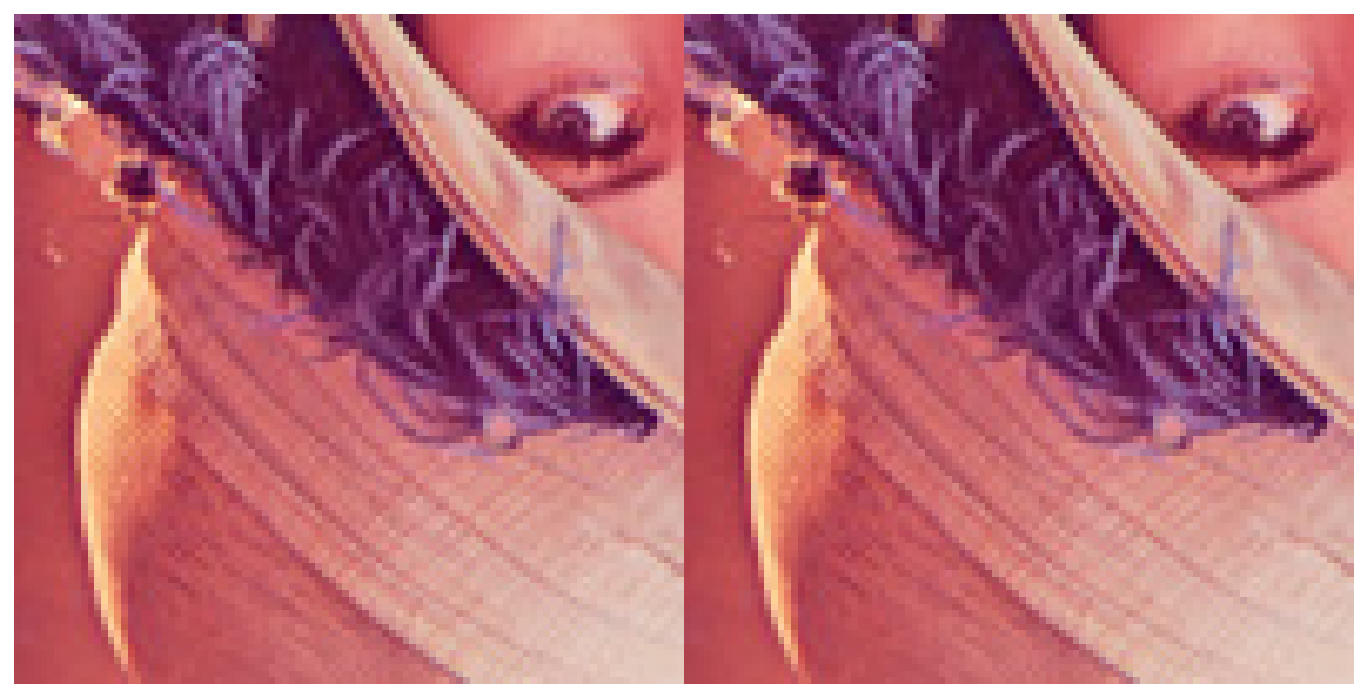

In [43]:
img_3 = cv2.flip(img_2, 0)
print(img_3.shape)
show_image(img_3)

(200, 200, 3)


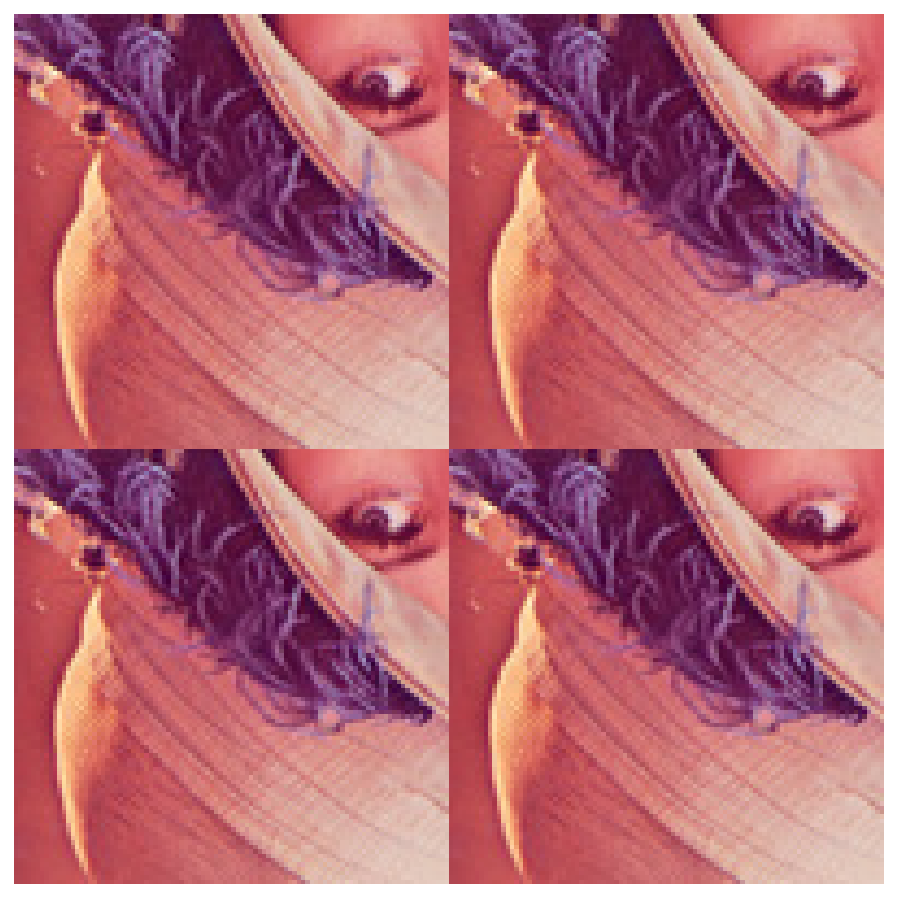

In [44]:
img_4 = np.vstack([img_3]*2)
print(img_4.shape)
show_image(img_4)

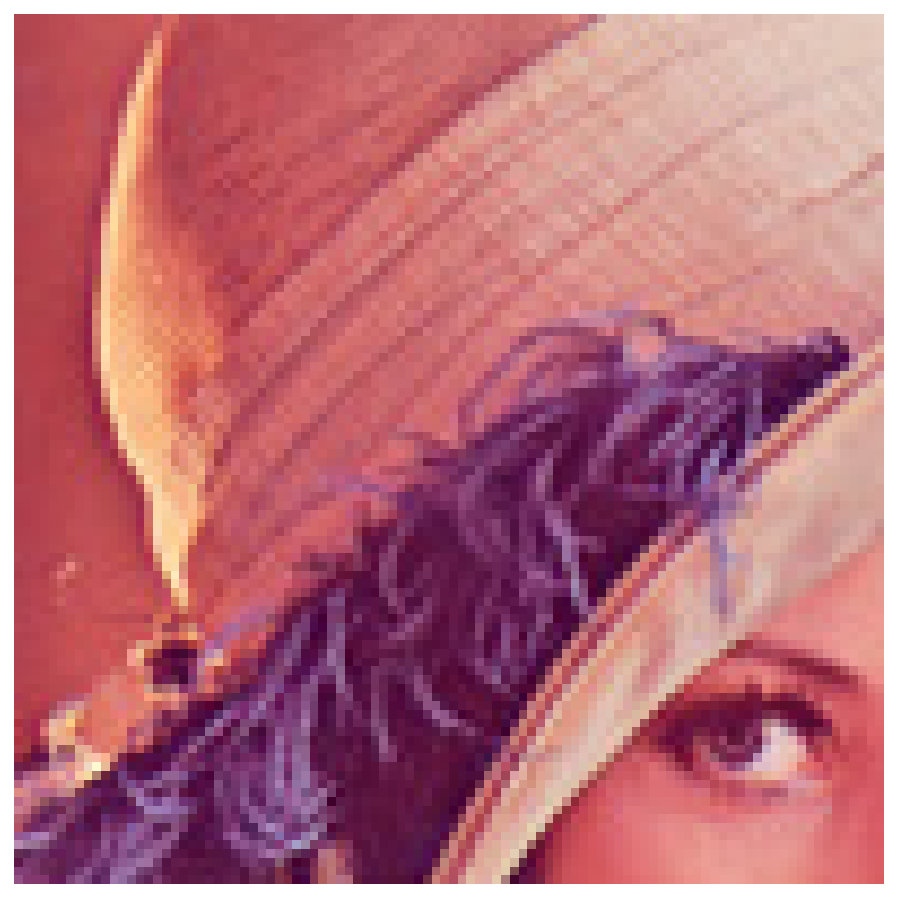

In [33]:
show_image(np.hstack([img1]*2))

## Flip

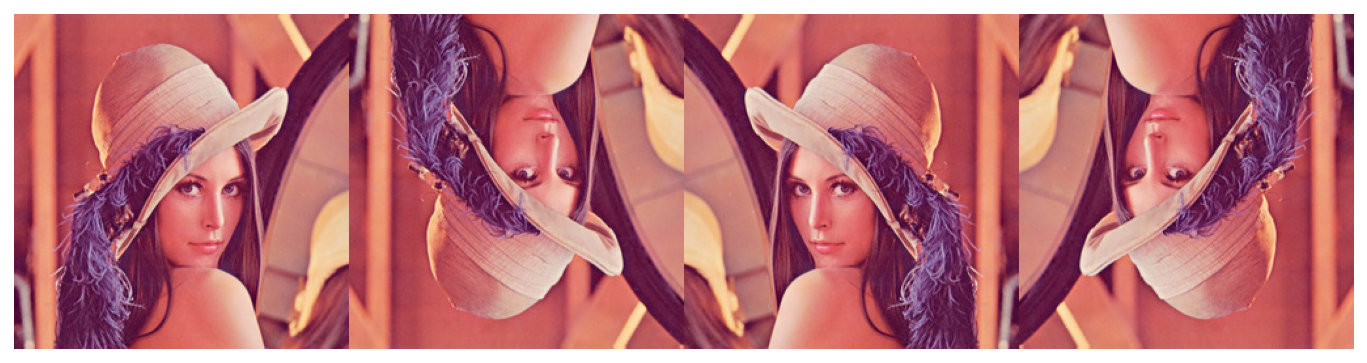

In [16]:
show_image(np.hstack([
    img_lena,
    cv2.flip(img_lena, 0),
    cv2.flip(img_lena, 1),
    cv2.flip(img_lena, -1),
]))

## Rotation

In [11]:
M = cv2.getRotationMatrix2D(center=(int(width / 2), int(height / 2)), angle=45, scale=1.0)
img_lena_rot = cv2.warpAffine(img_lena, M, (int(width/2), int(height/2)))

In [27]:
a = img_lena.copy()

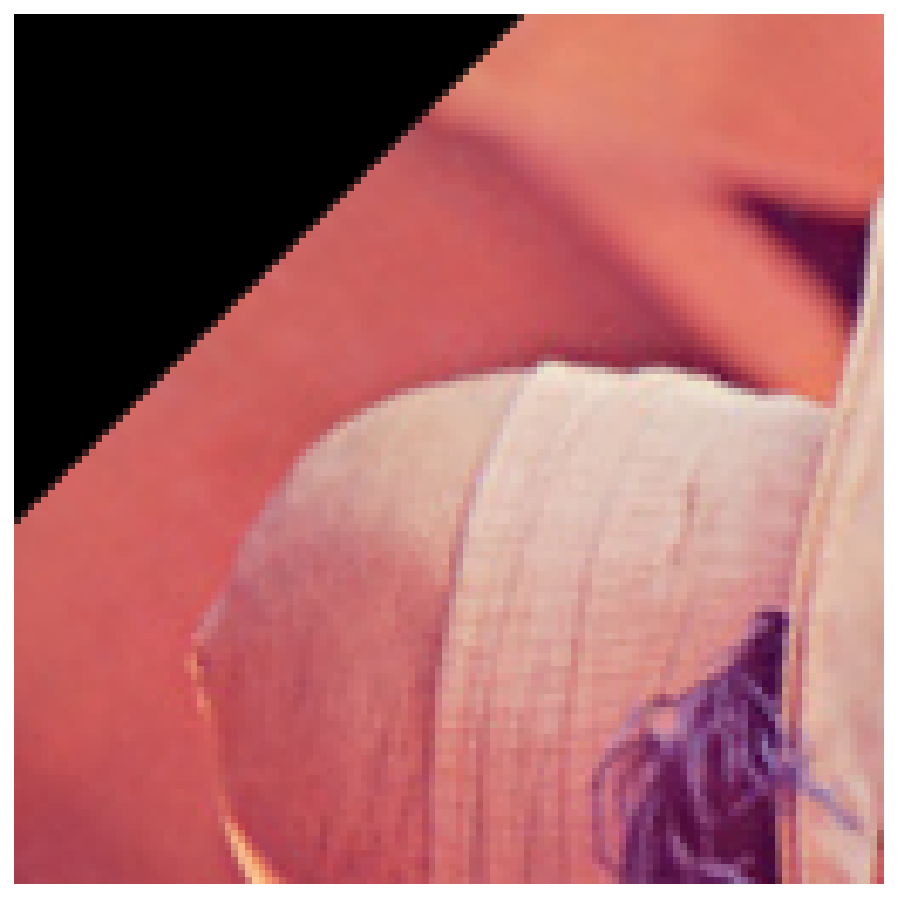

In [12]:
show_image(img_lena_rot)